In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import descartes
from shapely.geometry import Point,polygon
import zipfile
import contextily as ctx
import missingno as msno
from scipy.stats import chi2_contingency as chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import decomposition
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', 46);
pd.set_option('display.max_rows', 100)


In [4]:
df = pd.read_csv('projet_4_clean.csv',index_col=[0], )

In [5]:
df.shape

(1529, 31)

# Préparation des données

<Figure size 640x480 with 0 Axes>

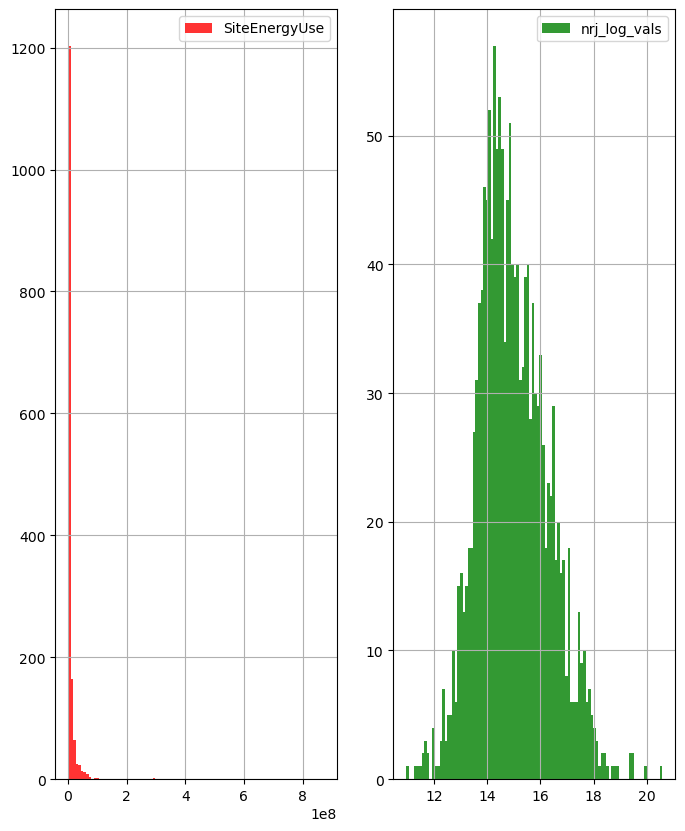

In [6]:
#Histogram On the log scale
df1 = df.copy()
df['nrj_log_vals'] = np.log(df['SiteEnergyUse'])
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(8,10))
df['nrj_log_vals'].hist(bins=100, alpha=0.8, legend=True,ax=ax[1],color='green')
df['SiteEnergyUse'].hist(bins=100, alpha=0.8,legend=True,ax=ax[0],color='red')
plt.show()


In [7]:
df.loc[df['Outlier']==1,:]

,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),YearsENERGYSTARCertified,ENERGYSTARScore,SiteEnergyUse,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,Autres,Education,EntertainmentPublicAssembly,FoodSalesService,Healthcare,LodgingResidential,Office,Other,Parking,ReligiousWorship,Retail,Sans,TechnologyScience,WarehouseStorage,nrj_log_vals
293,NonResidential,Large Office,1980,1,36,7.945920e+05,36606.0,7.579860e+05,2009.0,96.0,26689658.0,0.0,1.0,1.0,1,216.43,0.27,0,0,0,0.0,0,0,7.480110e+05,9975,36606.0,0,0.0,0,0,0,17.099787
292,NonResidential,Large Office,1989,1,56,1.735079e+06,389860.0,1.345219e+06,2009.0,97.0,49517704.0,1.0,1.0,1.0,1,525.78,0.33,0,0,0,0.0,0,0,1.314475e+06,30744,389860.0,0,0.0,0,0,0,17.717841
253,NonResidential,Large Office,1984,1,8,2.506530e+05,70190.0,1.804630e+05,2010.0,3.0,29949248.0,0.0,1.0,0.0,1,208.79,0.82,0,0,0,0.0,0,0,1.586810e+05,21782,70190.0,0,0.0,0,0,0,17.215015
410,NonResidential,MixedUse,1932,1,14,4.594569e+05,156487.0,3.029699e+05,2010.0,66.0,21027396.0,0.0,1.0,1.0,1,247.35,0.81,0,0,0,0.0,0,0,3.029699e+05,0,156487.0,0,0.0,0,0,0,16.861337
307,NonResidential,Autres,1992,1,14,5.407670e+05,270383.0,2.703840e+05,2012.0,58.0,21156670.0,0.0,1.0,0.0,1,147.49,0.21,0,0,0,0.0,0,0,2.703840e+05,0,270383.0,0,0.0,0,0,0,16.867466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,Nonresidential COS,Other,2004,1,11,4.149870e+05,49000.0,3.659870e+05,NaN,NaN,18588860.0,1.0,1.0,0.0,1,181.38,0.44,364913,0,0,0.0,0,0,0.000000e+00,0,49000.0,0,0.0,0,1074,0,16.738073
302,NonResidential,Retail,1929,1,8,8.899810e+05,0.0,8.899810e+05,NaN,NaN,17666646.0,1.0,1.0,1.0,1,328.83,0.38,0,0,0,0.0,0,0,0.000000e+00,380639,0.0,0,509342.0,0,0,0,16.687189
239,NonResidential,Large Office,1971,1,23,4.745460e+05,0.0,4.745460e+05,NaN,77.0,28450436.0,0.0,1.0,0.0,1,198.34,0.42,0,0,0,0.0,0,0,4.745460e+05,0,0.0,0,0.0,0,0,0,17.163674
3277,NonResidential,Autres,1998,1,6,2.030300e+05,0.0,2.030300e+05,NaN,NaN,51168308.0,0.0,1.0,0.0,1,199.48,0.98,0,203030,0,0.0,0,0,0.000000e+00,0,0.0,0,0.0,0,0,0,17.750631


In [8]:
df_test = df.drop(df.loc[df['Outlier']==1].index)

# Nouveau test avec sans et parking

#  X_train / X_test avec les variables d'origines sans EnergyStarScore

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
       'SiteEnergyUse', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'Sans', 'TechnologyScience', 'WarehouseStorage',
       'nrj_log_vals'],
      dtype='object')

In [11]:
energy = df.loc[~df['ENERGYSTARScore'].isna(),:]

In [12]:
X = df.drop(['SiteEnergyUse','TotalGHGEmissions', 'GHGEmissionsIntensity','YearsENERGYSTARCertified','PropertyGFAParking','PropertyGFABuilding(s)',
         
            'YearsENERGYSTARCertified','PropertyGFATotal','PrimaryPropertyType','Electricity(kBtu)','NumberofFloors','YearBuilt','BuildingType','NumberofBuildings','Sans', 
       'ENERGYSTARScore','nrj_log_vals'],axis=1);
y = df[['SiteEnergyUse']];
name = X.columns

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1529 entries, 252 to 544
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SteamUse(kBtu)               1529 non-null   float64
 1   NaturalGas(kBtu)             1529 non-null   float64
 2   Outlier                      1529 non-null   int64  
 3   Autres                       1529 non-null   int64  
 4   Education                    1529 non-null   int64  
 5   EntertainmentPublicAssembly  1529 non-null   int64  
 6   FoodSalesService             1529 non-null   float64
 7   Healthcare                   1529 non-null   int64  
 8   LodgingResidential           1529 non-null   int64  
 9   Office                       1529 non-null   float64
 10  Other                        1529 non-null   int64  
 11  Parking                      1529 non-null   float64
 12  ReligiousWorship             1529 non-null   int64  
 13  Retail           

In [14]:
name

Index(['SteamUse(kBtu)', 'NaturalGas(kBtu)', 'Outlier', 'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'TechnologyScience', 'WarehouseStorage'],
      dtype='object')

In [15]:
col_num = X.select_dtypes('number').columns;
col_quali = X.select_dtypes('object').columns

In [16]:
col_num

Index(['SteamUse(kBtu)', 'NaturalGas(kBtu)', 'Outlier', 'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'TechnologyScience', 'WarehouseStorage'],
      dtype='object')

In [17]:
col_quali

Index([], dtype='object')

In [18]:
from sklearn.compose import make_column_transformer

Colonne transformer permet d'appliquer un transformer sur les colonnes sélectionnées.  

Je commence par créer une pipeline par type de variables que j'appliquerai par la suite sur make_column_transformer


In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

In [20]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'),RobustScaler(unit_variance=True));
categorical_pipeline = make_pipeline( OneHotEncoder())

In [21]:
preprocessor = make_column_transformer((numerical_pipeline, col_num),
                                   (categorical_pipeline, col_quali))

In [22]:
X = preprocessor.fit_transform(X)

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,train_size=0.8,test_size=0.2)

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = name
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train, i)
                          for i in range(len(name))]

print(vif_data)

                        feature       VIF
0                SteamUse(kBtu)  1.215908
1              NaturalGas(kBtu)  1.145204
2                       Outlier  2.229806
3                        Autres  1.104436
4                     Education  1.092894
5   EntertainmentPublicAssembly  1.041728
6              FoodSalesService  1.202752
7                    Healthcare  1.362919
8            LodgingResidential  1.272067
9                        Office  2.891937
10                        Other  1.161782
11                      Parking  2.485065
12             ReligiousWorship  1.001578
13                       Retail  1.192827
14            TechnologyScience  1.155254
15             WarehouseStorage  1.126095


# Modèle de base

In [25]:
from sklearn.dummy import DummyRegressor

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [27]:
from sklearn.linear_model import LinearRegression 

## Sélection de modèles

In [28]:
from sklearn.metrics import *

In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

In [30]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score



In [31]:
# Modèles sélectionnés:
dummy_reg = DummyRegressor(strategy='median')
lin_reg = LinearRegression()
ridge = Ridge(random_state=0)
lasso = Lasso(random_state=0)
dec_tree =  DecisionTreeRegressor(random_state=0)
svm = SVR()
adaboost = AdaBoostRegressor(random_state=0)
bagging = BaggingRegressor(random_state=0)
gradientboosting = GradientBoostingRegressor(random_state=0)
forest = RandomForestRegressor(random_state=0)
xgboost = xgb.XGBRegressor(random_state=0)
Knregressor = KNeighborsRegressor()

In [32]:
name

Index(['SteamUse(kBtu)', 'NaturalGas(kBtu)', 'Outlier', 'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'TechnologyScience', 'WarehouseStorage'],
      dtype='object')

# Evaluation des différents modèles de regression

Comparaison des méthodes
Pour la comparaison des methodes on vas baser sur :

Le RMSE (root mean squared error) fournit une indication sur la variance du modèle prédit. Plus précisément, il caractérise la taille des écarts entre observations et les mesures. Les valeurs du RMSE sont comprises entre [0;+∞[. Plus la valeur du critère RMSE est proche de zéro, meilleur est le modèle évalué en terme d’exactitude. Il faut donc minimiser la valeur du RMSE et choisir un modèle avec le RMSE le plus faible pour avoir un modèle qui se rapproche le plus des valeurs réelles.

MSE (Mean Square Error )Le carré moyen des erreurs : c’est la moyenne arithmétique des carrés des écarts entre prévisions du modèle et observations.C’est la valeur à minimiser dans le cadre d’une régression simple ou multiple. La méthode est fondée sur la nullité de la moyenne des résidus. Mais la moyenne de leurs carrés n'est généralement pas nulle. Cette moyenne n'est autre que la VARIANCE RÉSIDUELLE que l'on cherche à minimise

MAE (Mean Absolute Error)L’erreur absolue moyenne : moyenne arithmétique des valeurs absolues des écarts.

R2 correspond au coefficient de détermination et il s'agit du carré de la corrélation de Pearson entre les vraies valeurs et les valeurs prédites. Le coefficient de détermination nous indique donc à quel point les valeurs prédites sont corrélées aux vraies valeurs. Un modèle avec un R2 élevé prédit donc des valeurs prochent des données réelles et il est donc un bon modèle à priviléger pour notre problème. Il faut donc maximiser la valeur du R2.

In [33]:
# Création d'un dictionnaire de modèle
models = {'dummy_reg': DummyRegressor(strategy='median'),
    'lin_reg': LinearRegression(),
    'ridge' : Ridge(random_state=0),
    'lasso' : Lasso(random_state=0),
    'dec_tree':  DecisionTreeRegressor(random_state=0),
    'svm' : SVR(),
    'adaboost' :AdaBoostRegressor(random_state=0),
    'bagging ': BaggingRegressor(random_state=0),
    'gradientboosting ': GradientBoostingRegressor(random_state=0),
    'forest' : RandomForestRegressor(random_state=0),
    'xgboost' : xgb.XGBRegressor(random_state=0),
    'Knregressor' : KNeighborsRegressor()}

In [34]:
def evaluation_model(models,X_train,X_test,y_train,y_test):
    results = []
    for i, model in enumerate(models):
        
        models[model].fit(X_train, y_train)
        # Calcul du temps d'entraînement
        start_time_train = time.time()
        r2_train = models[model].score(X_train,y_train)
        time_end_train = time.time()
        # fin d'exécution
        
        # Calcul du temps de prédiction
        start_time_pred = time.time()
        y_pred = models[model].predict(X_test)
        time_end_pred = time.time()
        # fin d'exécution
                
        r2_predict = r2_score(y_test, y_pred)
        MAE = mean_absolute_error(y_test, y_pred)
        MSE = mean_squared_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # durée d'exécution de l'entraînement 
        time_execution_train = time_end_train - start_time_train
        
        # durée d'exécution de la prédiction
        time_execution_pred = time_end_pred - start_time_pred
   
    
        results.append([round(MAE,3),round(MSE,3),round(RMSE,3),round(r2_train,3),time_execution_train,round(r2_predict,3),time_execution_pred])
    return pd.DataFrame(results, columns=['MAE','MSE','RMSE','R2_train','Time_train','R2_predict','Time_predict'], index=models.keys())

In [35]:
evaluation_model( models,X_train,X_test,y_train,y_test)

,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
dummy_reg,9002138.910,2.663564e+15,5.160972e+07,-0.058,0.000000,-0.022,0.000000
lin_reg,4091229.361,5.102316e+14,2.258831e+07,0.844,0.000000,0.804,0.000000
ridge,4086446.954,5.084431e+14,2.254868e+07,0.844,0.000000,0.805,0.000000
lasso,4091228.332,5.102314e+14,2.258830e+07,0.844,0.000000,0.804,0.000000
dec_tree,6947660.369,2.306834e+15,4.802951e+07,1.000,0.000000,0.115,0.000000
svm,9002111.127,2.663564e+15,5.160972e+07,-0.058,0.140635,-0.022,0.047123
adaboost,7533368.363,2.349367e+15,4.847027e+07,0.889,0.000000,0.098,0.000000
bagging,6274996.485,2.312828e+15,4.809187e+07,0.932,0.000000,0.113,0.000000
gradientboosting,6383223.419,2.239674e+15,4.732520e+07,0.976,0.000000,0.141,0.000000
forest,6172276.194,2.319488e+15,4.816106e+07,0.938,0.031251,0.110,0.000000


In [36]:
# Je crée une liste des modèles que je veux évaluer
liste = [dummy_reg,lin_reg, ridge,lasso,dec_tree,svm,adaboost,bagging,gradientboosting,forest,xgboost,Knregressor]

In [37]:
def predic_plot(model): 
    label=['y_pred','y_test']
    model.fit(X_train,y_train)
    plt.plot(model.predict(X_test),y_test,'o',label=label,alpha=0.5)
    min_tru=y_test.min()
    max_tru=y_test.max()
    plt.plot([min_tru, max_tru], [min_tru, max_tru], '--') 
    plt.title('Comparaison de Y_pred et Y_test')
    plt.xlabel("Y_pred")
    plt.ylabel("Y_test")
    plt.legend(label)
    plt.show()

DummyRegressor(strategy='median')


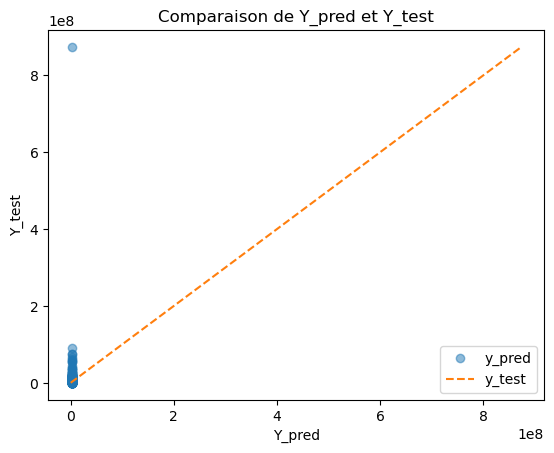


---------------------------------------------
LinearRegression()


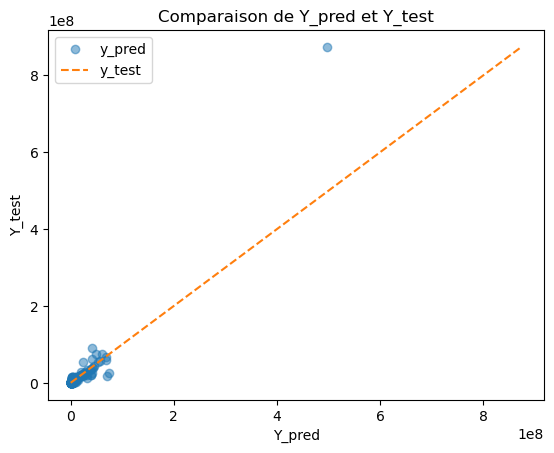


---------------------------------------------
Ridge(random_state=0)


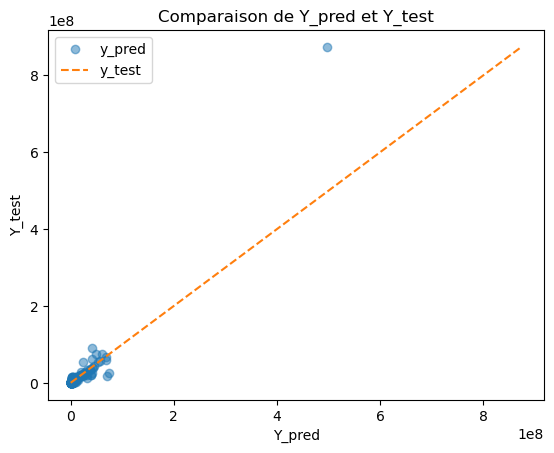


---------------------------------------------
Lasso(random_state=0)


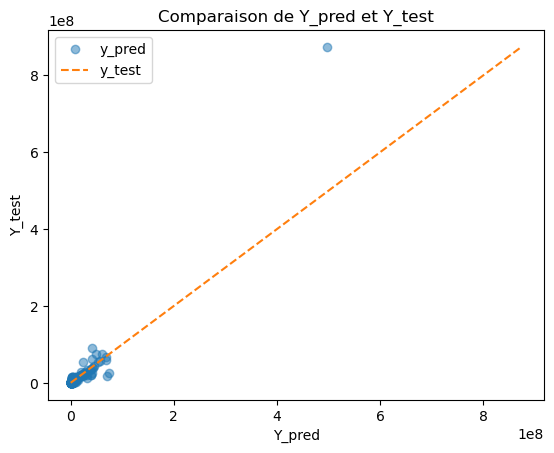


---------------------------------------------
DecisionTreeRegressor(random_state=0)


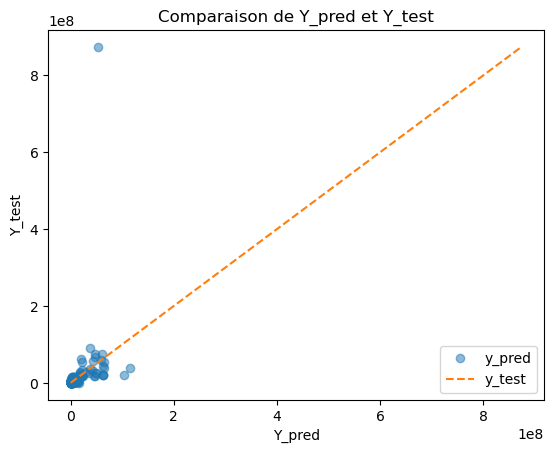


---------------------------------------------
SVR()


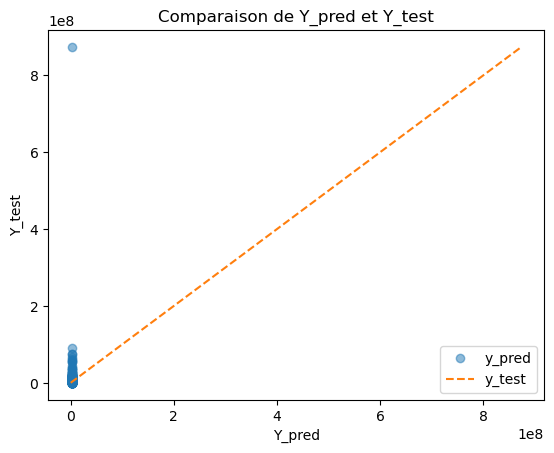


---------------------------------------------
AdaBoostRegressor(random_state=0)


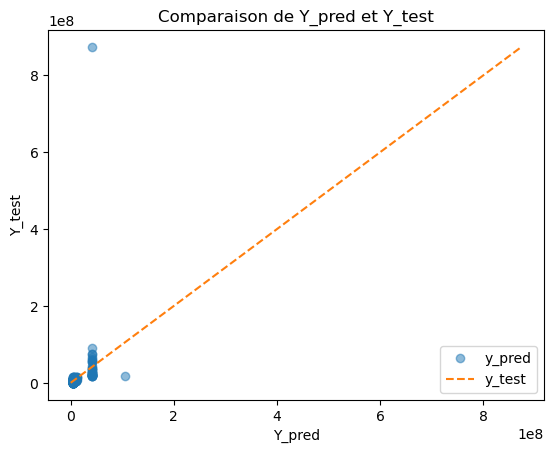


---------------------------------------------
BaggingRegressor(random_state=0)


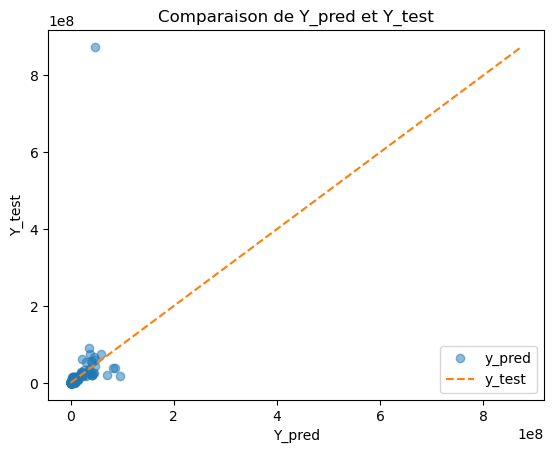


---------------------------------------------
GradientBoostingRegressor(random_state=0)


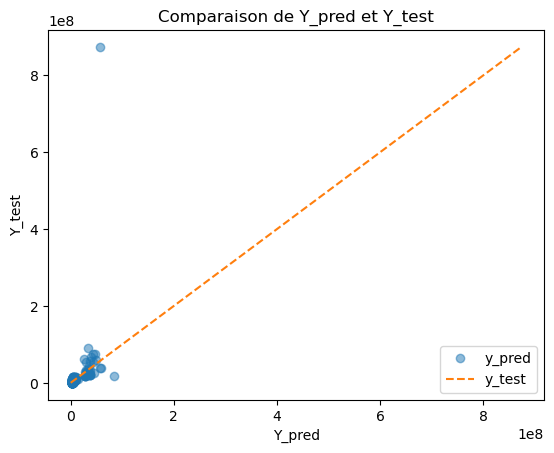


---------------------------------------------
RandomForestRegressor(random_state=0)


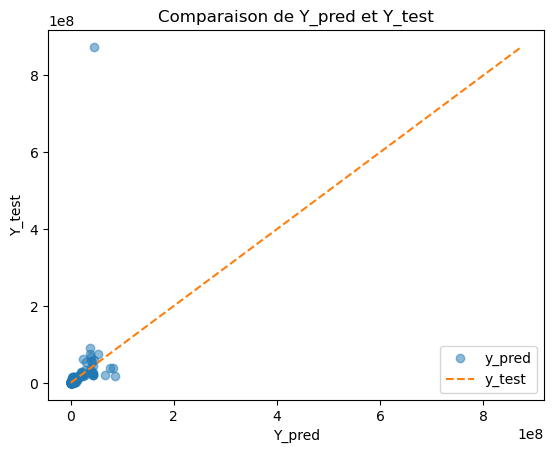


---------------------------------------------
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=0,
             reg_alpha=None, reg_lambda=None, ...)


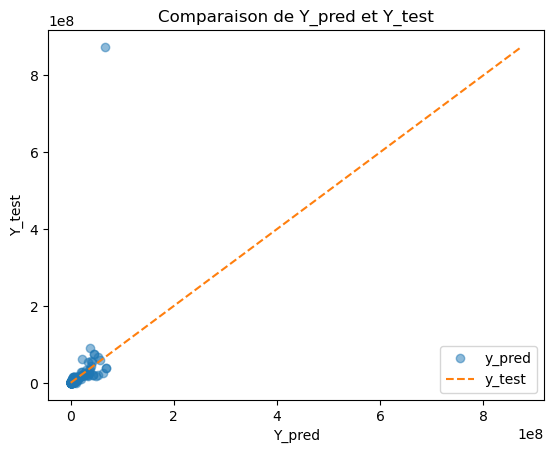


---------------------------------------------
KNeighborsRegressor()


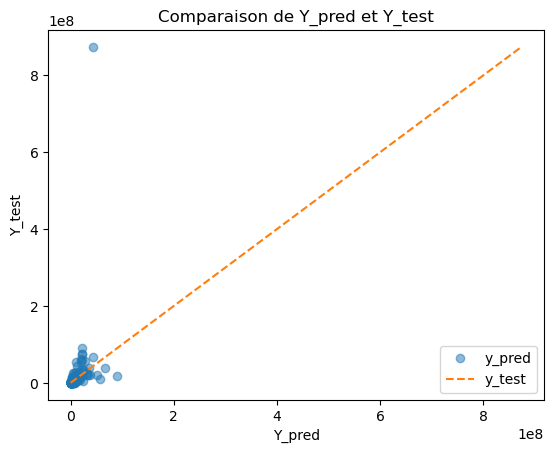


---------------------------------------------


In [38]:
for mod in liste:
    print(mod)
    predic_plot(mod)
    print('')
    print('-'*45)

# Optimisation des paramètres

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.7017081112825811
Best Params:  {'alpha': 1000}


In [41]:
grid_result.score(X_test,y_test)

0.8609870236271336

In [42]:
y_pred = grid_result.predict(X_test)

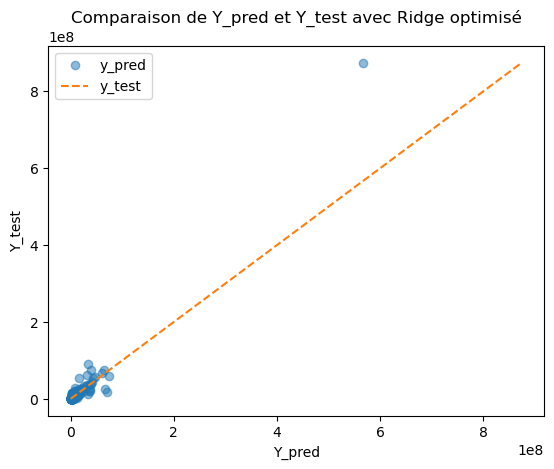

In [43]:
label=['y_pred','y_test']
plt.plot(y_pred,y_test,'o',alpha=0.5, label=label)

min_tru=y_test.min()
max_tru=y_test.max()
plt.plot([min_tru, max_tru], [min_tru, max_tru], '--') 
plt.title('Comparaison de Y_pred et Y_test avec Ridge optimisé')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.legend(label)
plt.show()

In [44]:
from yellowbrick.regressor import ResidualsPlot


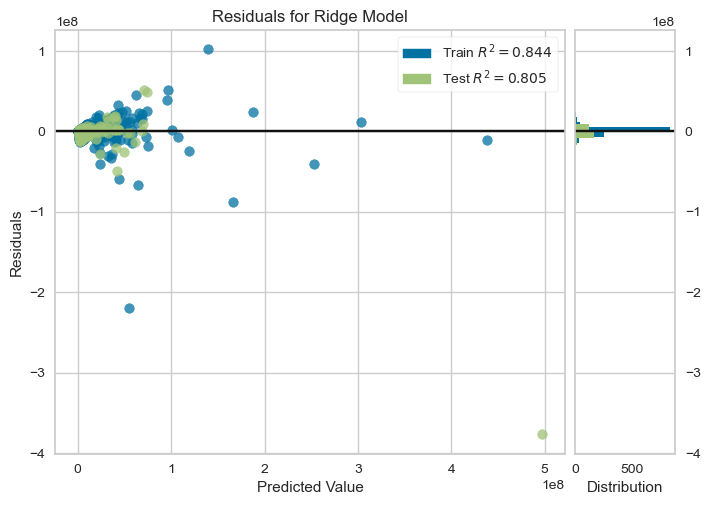

<AxesSubplot: title={'center': 'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [45]:
visualizer = ResidualsPlot(ridge,hist=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   4., 297.,   4.]),
 array([-3.07696943e+08, -2.71772442e+08, -2.35847941e+08, -1.99923440e+08,
        -1.63998939e+08, -1.28074438e+08, -9.21499364e+07, -5.62254353e+07,
        -2.03009342e+07,  1.56235669e+07,  5.15480680e+07]),
 <BarContainer object of 10 artists>)

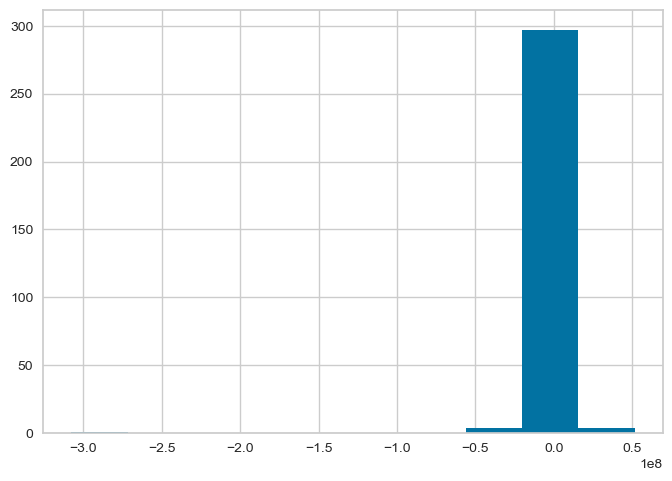

In [46]:
residuals = y_pred - y_test;
plt.hist(residuals)


# Modéle avec EnergieScore

In [47]:
energy = df.loc[~df['ENERGYSTARScore'].isna(),:]

In [48]:
X_score = df.drop(['SiteEnergyUse','TotalGHGEmissions', 'GHGEmissionsIntensity','YearsENERGYSTARCertified','PropertyGFAParking','PropertyGFABuilding(s)',
         
            'YearsENERGYSTARCertified','PropertyGFATotal','PrimaryPropertyType','NumberofFloors','YearBuilt','BuildingType','NumberofBuildings','Sans', 
       'nrj_log_vals'],axis=1);
y_score = df[['SiteEnergyUse']];
name_score = X_score.columns

In [49]:
X_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1529 entries, 252 to 544
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ENERGYSTARScore              993 non-null    float64
 1   SteamUse(kBtu)               1529 non-null   float64
 2   Electricity(kBtu)            1529 non-null   float64
 3   NaturalGas(kBtu)             1529 non-null   float64
 4   Outlier                      1529 non-null   int64  
 5   Autres                       1529 non-null   int64  
 6   Education                    1529 non-null   int64  
 7   EntertainmentPublicAssembly  1529 non-null   int64  
 8   FoodSalesService             1529 non-null   float64
 9   Healthcare                   1529 non-null   int64  
 10  LodgingResidential           1529 non-null   int64  
 11  Office                       1529 non-null   float64
 12  Other                        1529 non-null   int64  
 13  Parking          

In [50]:
name_score

Index(['ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'Outlier', 'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'TechnologyScience', 'WarehouseStorage'],
      dtype='object')

In [51]:
col_num_score = X_score.select_dtypes('number').columns;
col_quali_score = X_score.select_dtypes('object').columns

In [52]:
col_num_score

Index(['ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'Outlier', 'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'TechnologyScience', 'WarehouseStorage'],
      dtype='object')

In [53]:
col_quali_score

Index([], dtype='object')

In [54]:
preprocessor_score = make_column_transformer((numerical_pipeline, col_num_score),
                                   (categorical_pipeline, col_quali_score))

In [55]:
X_score = preprocessor_score.fit_transform(X_score)

In [56]:
X_train_score,X_test_score,y_train_score,y_test_score = train_test_split(X_score, y_score, random_state=0,train_size=0.8,test_size=0.2)

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = name_score
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_score, i)
                          for i in range(len(name_score))]

print(vif_data)

                        feature       VIF
0               ENERGYSTARScore  1.085589
1                SteamUse(kBtu)  1.216164
2             Electricity(kBtu)  1.002836
3              NaturalGas(kBtu)  1.145733
4                       Outlier  2.289408
5                        Autres  1.111186
6                     Education  1.096256
7   EntertainmentPublicAssembly  1.042416
8              FoodSalesService  1.202755
9                    Healthcare  1.363865
10           LodgingResidential  1.272127
11                       Office  2.980832
12                        Other  1.163746
13                      Parking  2.486720
14             ReligiousWorship  1.001856
15                       Retail  1.196514
16            TechnologyScience  1.165039
17             WarehouseStorage  1.126445


In [58]:
evaluation_model( models,X_train_score,X_test_score,y_train_score,y_test_score)

,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
dummy_reg,9002138.910,2.663564e+15,5.160972e+07,-0.058,0.000000,-0.022,0.000000
lin_reg,4014992.243,4.909522e+14,2.215744e+07,0.845,0.000000,0.812,0.000000
ridge,4010743.925,4.892156e+14,2.211822e+07,0.845,0.000000,0.812,0.000000
lasso,4014991.350,4.909520e+14,2.215744e+07,0.845,0.000000,0.812,0.000000
dec_tree,6339516.613,2.294049e+15,4.789623e+07,1.000,0.000000,0.120,0.000000
svm,9002111.156,2.663564e+15,5.160972e+07,-0.058,0.166495,-0.022,0.038040
adaboost,7342353.640,2.330504e+15,4.827529e+07,0.886,0.000000,0.106,0.000000
bagging,5904539.921,2.297102e+15,4.792809e+07,0.920,0.000000,0.119,0.013233
gradientboosting,6519571.090,2.251071e+15,4.744546e+07,0.980,0.000000,0.136,0.000000
forest,5944231.734,2.325810e+15,4.822665e+07,0.936,0.021435,0.108,0.009081


In [59]:
def predic_plot_score(model): 
    label=['y_pred','y_test']
    model.fit(X_train_score,y_train_score)
    plt.plot(model.predict(X_test_score),y_test_score,'o',label=label,alpha=0.5)
    min_tru=y_test_score.min()
    max_tru=y_test_score.max()
    plt.plot([min_tru, max_tru], [min_tru, max_tru], '--') 
    plt.title('Comparaison de Y_pred et Y_test')
    plt.xlabel("Y_pred")
    plt.ylabel("Y_test")
    plt.legend(label)
    plt.show()

DummyRegressor(strategy='median')


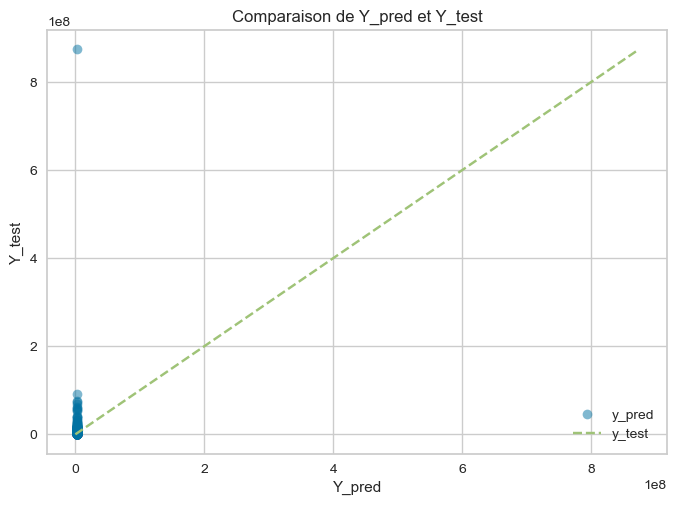


---------------------------------------------
LinearRegression()


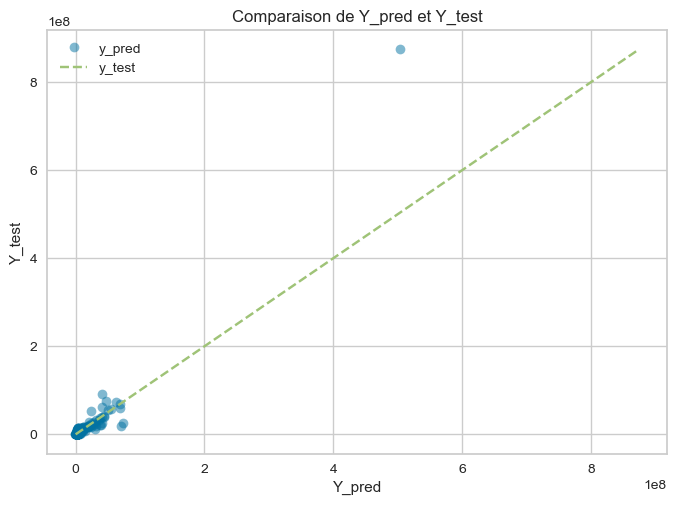


---------------------------------------------
Ridge(random_state=0)


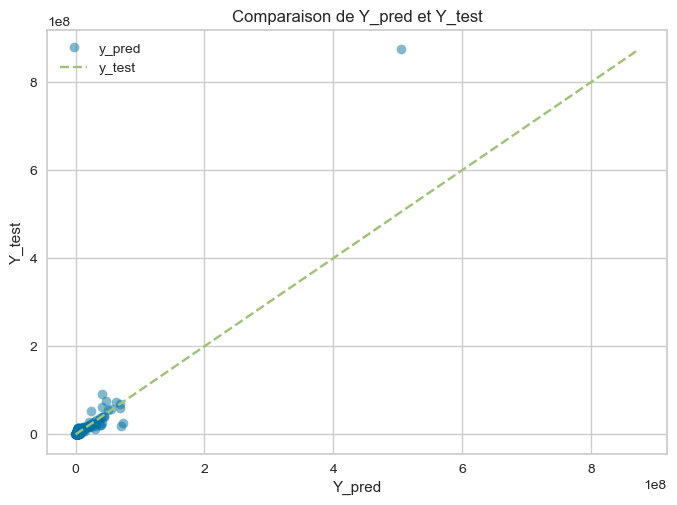


---------------------------------------------
Lasso(random_state=0)


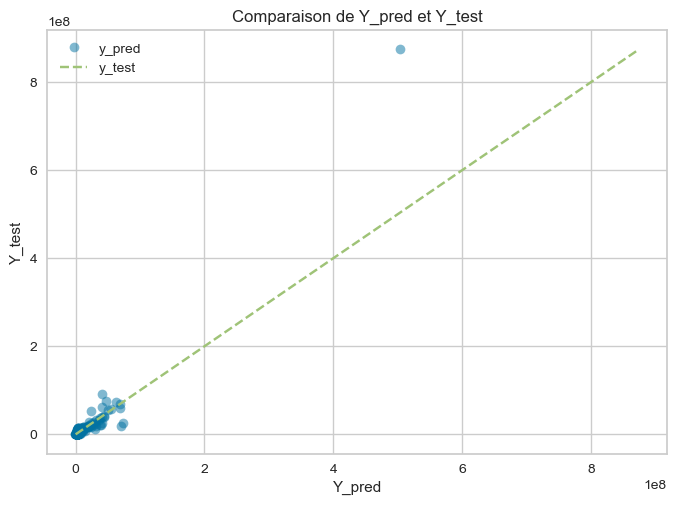


---------------------------------------------
DecisionTreeRegressor(random_state=0)


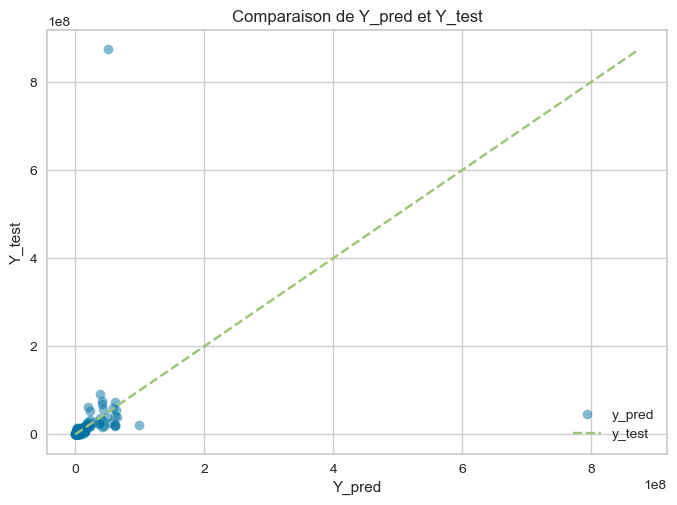


---------------------------------------------
SVR()


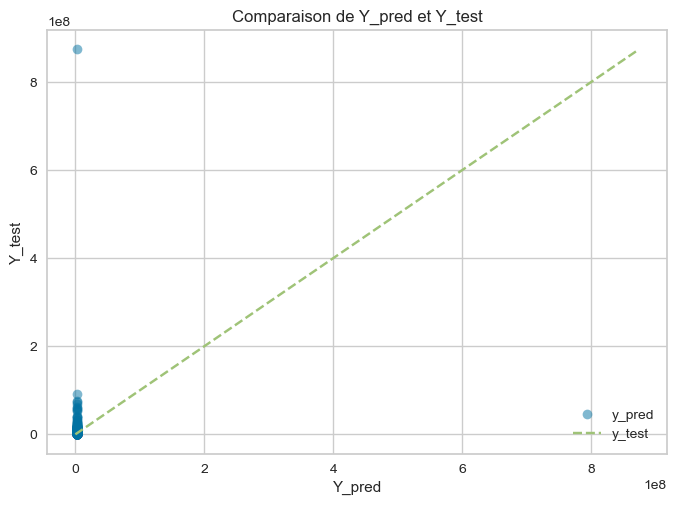


---------------------------------------------
AdaBoostRegressor(random_state=0)


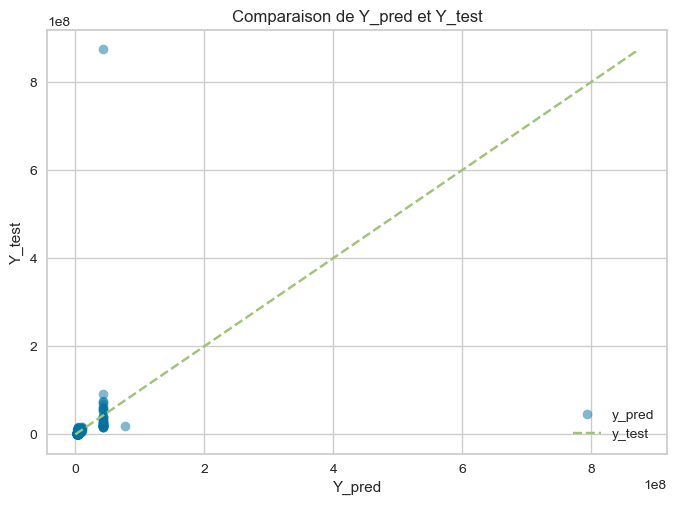


---------------------------------------------
BaggingRegressor(random_state=0)


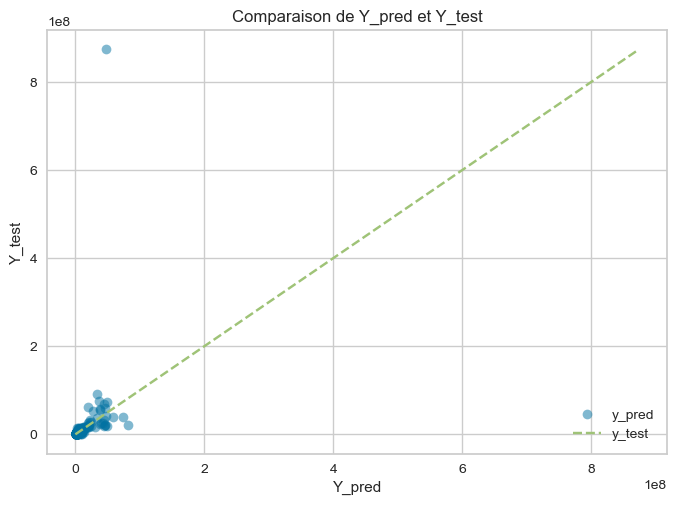


---------------------------------------------
GradientBoostingRegressor(random_state=0)


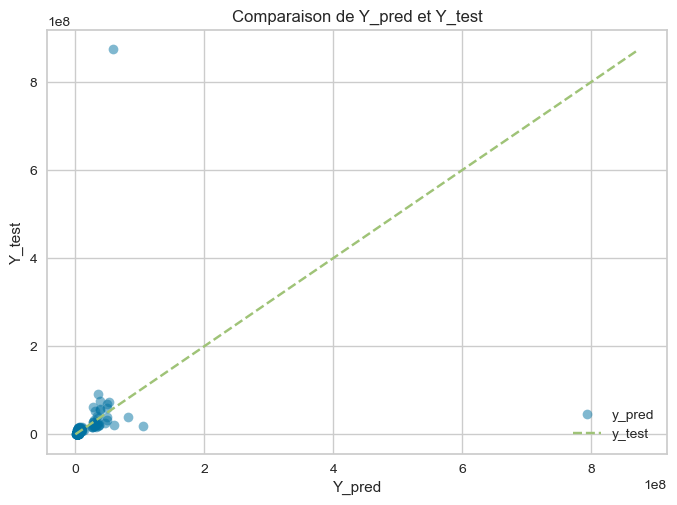


---------------------------------------------
RandomForestRegressor(random_state=0)


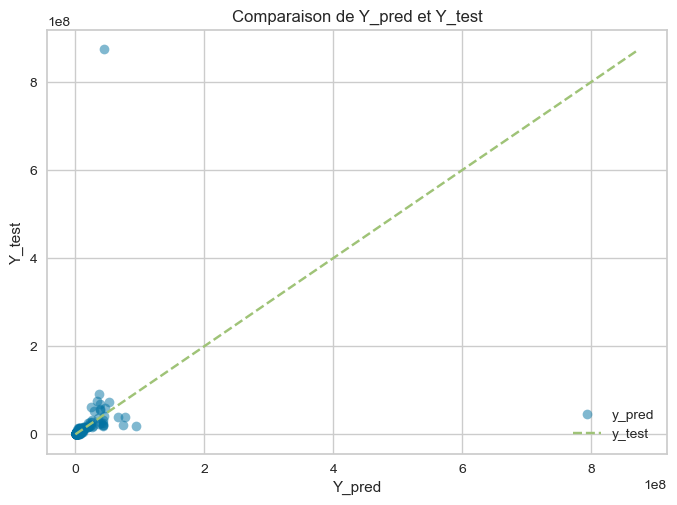


---------------------------------------------
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)


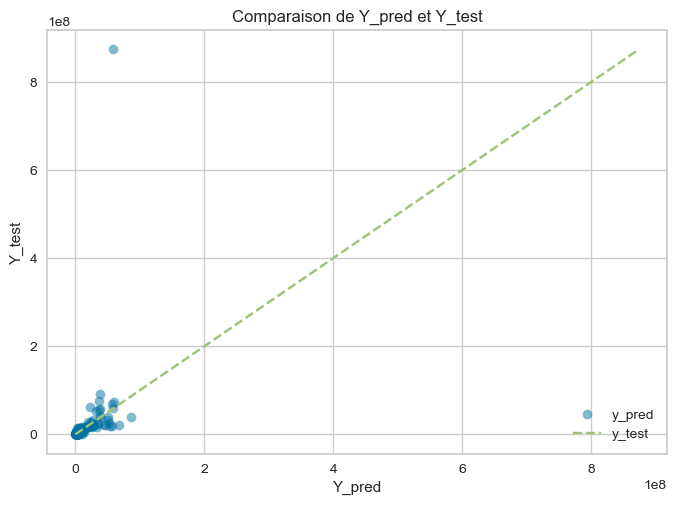


---------------------------------------------
KNeighborsRegressor()


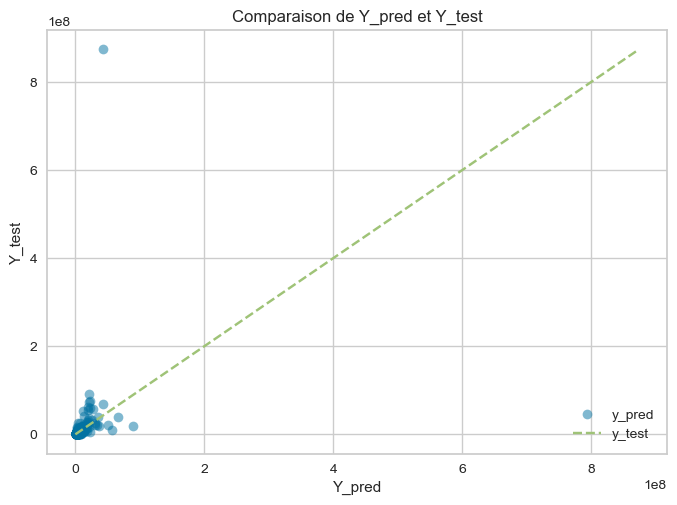


---------------------------------------------


In [60]:
for mod in liste:
    print(mod)
    predic_plot_score(mod)
    print('')
    print('-'*45)

# Optimisation du modèle

In [61]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_score, y_train_score)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.7027208056793866
Best Params:  {'alpha': 1000}


In [62]:
grid_result.score(X_test_score,y_test_score)

0.8649400712865134

In [63]:
y_pred_score = grid_result.predict(X_test_score)

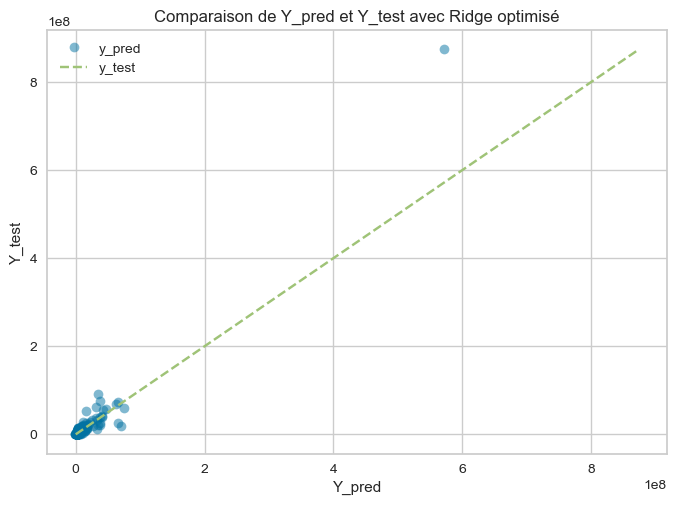

In [64]:
label=['y_pred','y_test']
plt.plot(y_pred_score,y_test_score,'o',label=label,alpha=0.5)
min_tru=y_test_score.min()
max_tru=y_test_score.max()
plt.plot([min_tru, max_tru], [min_tru, max_tru], '--') 
plt.title('Comparaison de Y_pred et Y_test avec Ridge optimisé')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.legend(label)
plt.show()


https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

In [65]:
from yellowbrick.regressor import ResidualsPlot


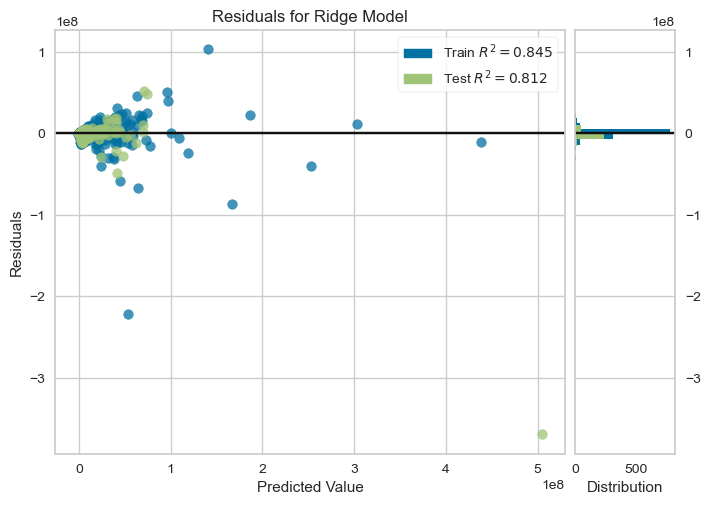

<AxesSubplot: title={'center': 'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [66]:
visualizer = ResidualsPlot(ridge,hist=True)

visualizer.fit(X_train_score, y_train_score)  # Fit the training data to the visualizer
visualizer.score(X_test_score, y_test_score)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   3., 297.,   4.]),
 array([-3.03040597e+08, -2.67551525e+08, -2.32062453e+08, -1.96573381e+08,
        -1.61084309e+08, -1.25595238e+08, -9.01061657e+07, -5.46170939e+07,
        -1.91280221e+07,  1.63610497e+07,  5.18501216e+07]),
 <BarContainer object of 10 artists>)

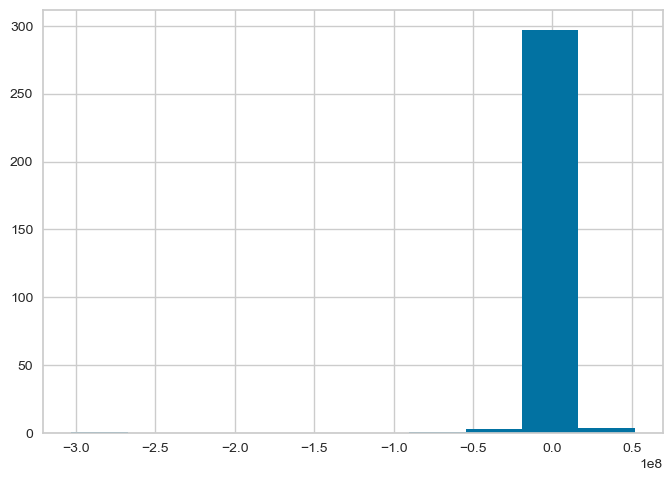

In [67]:
residual = y_pred_score - y_test_score;
plt.hist(residual)
